In [1]:
import glob, os, re
import cv2
import visualization as vis

height, width = 720, 1280

def IOU(boxA, boxB): # VOC
    (xminA, yminA, xmaxA, ymaxA), (xminB, yminB, xmaxB, ymaxB) = boxA, boxB
    inter = max(0,min(ymaxA,ymaxB)-max(yminA,yminB)) * max(0,min(xmaxA,xmaxB)-max(xminA,xminB))
    areaA = (ymaxA-yminA) * (xmaxA-xminA)
    areaB = (ymaxB-yminB) * (xmaxB-xminB)
    return inter / (areaA+areaB-inter) if (areaA+areaB-inter)!=0 else 0

class OverlapDetector:
    def __init__(self, pathD, iouThreshold=0.5):
        print(len(pathD))
        self.pathD        = pathD
        self.iouThreshold = iouThreshold
        self.defaultWH    = True
        self.overlapL     = []

    def process(self):
        for antPath,imgPath in self.pathD.items():
            if self.defaultWH:
                global height, width
            else:
                height, width, _ = cv2.imread(imgPath).shape
            boxL, lineL = [], open(antPath,"r").readlines()
            for line in lineL:
                cid, cx, cy, w, h = line.split(" ")
                xmin = int((float(cx)-float(w)/2)*width)
                ymin = int((float(cy)-float(h)/2)*height)
                xmax = int((float(cx)+float(w)/2)*width)
                ymax = int((float(cy)+float(h)/2)*height)
                boxL.append( (cid,xmin,ymin,xmax,ymax) )
            
            for i in range(len(boxL)-1):
                for j in range(i+1,len(boxL)):
                    iou = IOU( boxL[i][1:], boxL[j][1:] )
                    if iou>=self.iouThreshold:
                        self.overlapL.append( (iou,antPath,imgPath,lineL[i],lineL[j]) )
        print( len(self.overlapL) )

In [2]:
allFolders = "/home/jovyan/data-vol-2/recycling/backboneData/"
imgFolders = sorted(glob.glob(f"{allFolders}/20[0-9][0-9]-[0-9][0-9]-[0-9][0-9]"))
antFolders = sorted(glob.glob(f"{allFolders}/*_*"))

L = []
for imgFolder in imgFolders:
    imgDay = imgFolder.split("/")[-1]
    for antFolder in antFolders:
        antDay = re.findall("/([0-9,-]{10})", antFolder)[0]
        if imgDay==antDay:
            L.append( (imgFolder,antFolder) )

L
#[ (imgFolder.split("/")[-1], antFolder.split("/")[-1]) for imgFolder,antFolder in L ]

[('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14',
  '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14_label_nonpapercontainer_v3'),
 ('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14',
  '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14_label_papercontainer_v5'),
 ('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14',
  '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14_label_tetra_v5'),
 ('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-16',
  '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-16_label_tetra_v2'),
 ('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-21',
  '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-21_label_nonpapercontainer_v1'),
 ('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-21',
  '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-21_label_papercontainer_v1'),
 ('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-21',
  '/home/jovyan/data-vol-2/recycling/backbo

In [3]:
pathD = {} # antPath -> imgPath
for imgFolder,antFolder in L:
    imgPathL, antPathL = sorted(glob.glob(f"{imgFolder}/*.jpg")), sorted(glob.glob(f"{antFolder}/*.txt"))
    assert len(imgPathL)==len(antPathL)
    for antPath,imgPath in zip(antPathL, imgPathL):
        assert antPath.split("/")[-1].replace(".txt","")==imgPath.split("/")[-1].replace(".jpg","") 
        pathD[antPath] = imgPath
        
next(iter(pathD)), pathD[next(iter(pathD))]

('/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14_label_nonpapercontainer_v3/20220614_100019_684.txt',
 '/home/jovyan/data-vol-2/recycling/backboneData/2022-06-14/20220614_100019_684.jpg')

In [4]:
obj = OverlapDetector(pathD)
obj.process()

103759
7


0.510871997233692 
 2 0.132422 0.773611 0.182031 0.291667
 2 0.158125 0.779236 0.121875 0.223750


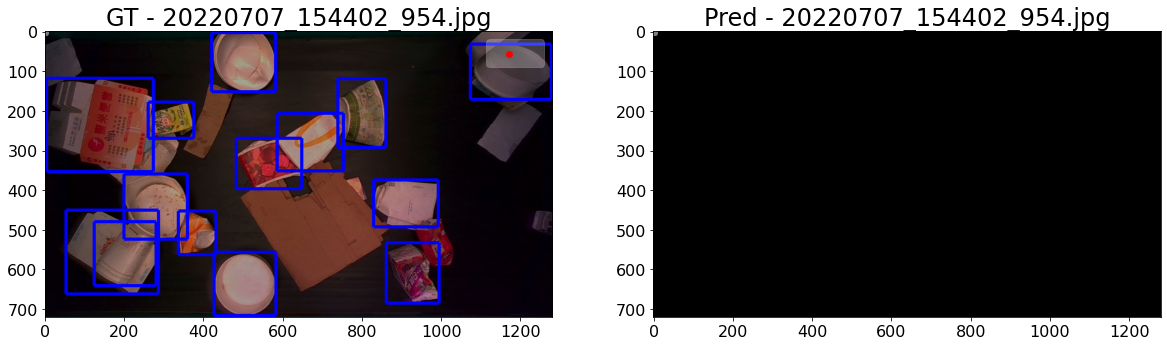

0.5205843293492696 
 2 0.687383 0.774653 0.196172 0.300139
 2 0.727734 0.758403 0.114844 0.266806


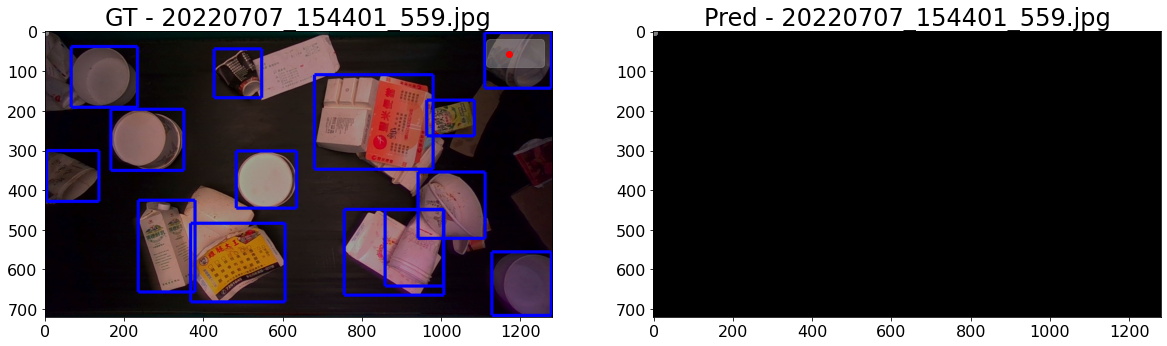

0.9056296778392451 
 0 0.298828 0.686111 0.074219 0.169444
 0 0.301953 0.684028 0.075781 0.170833


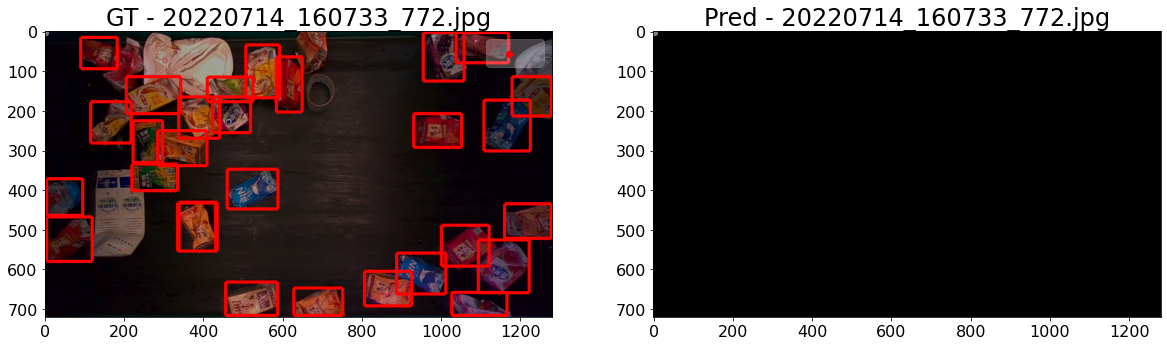

0.9211722488038278 
 2 0.817187 0.471528 0.082812 0.209722
 2 0.817422 0.473333 0.079531 0.219167


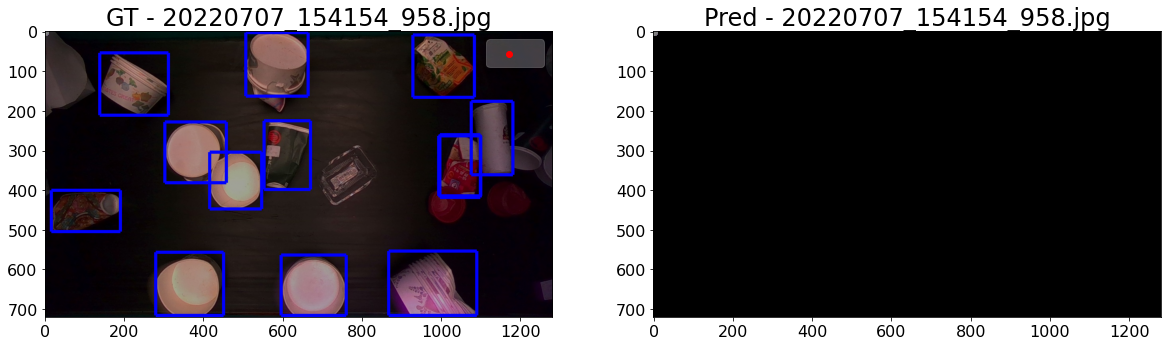

0.9373219373219374 
 1 0.652734 0.515972 0.166406 0.201389
 1 0.655484 0.515354 0.167516 0.195819


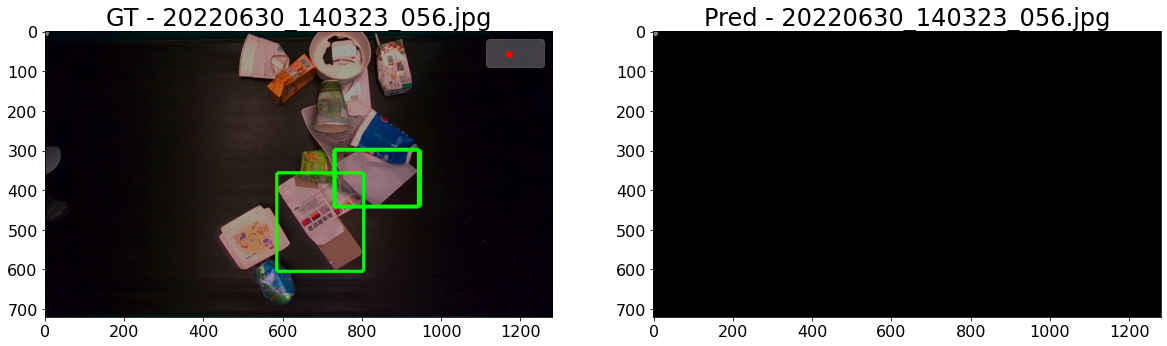

0.9402612370341913 
 2 0.709766 0.774306 0.208594 0.381944
 2 0.711719 0.775694 0.214062 0.395833


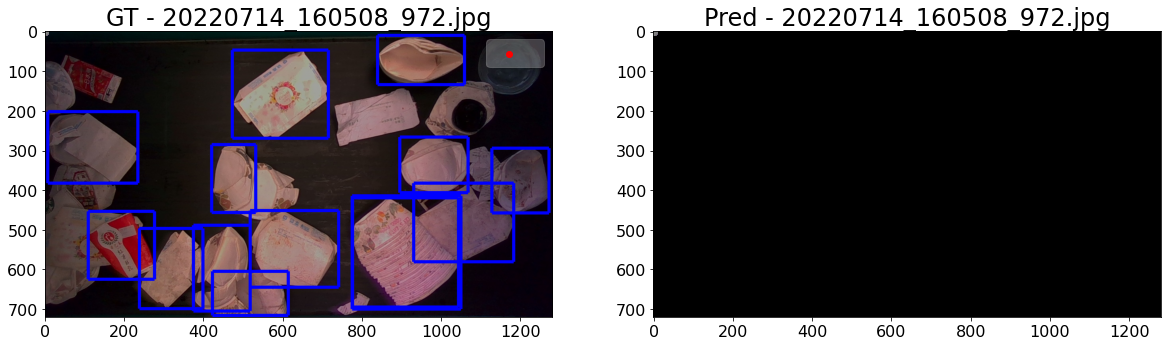

0.979714766586943 
 1 0.730469 0.797222 0.123438 0.388889
 1 0.730676 0.799639 0.124492 0.394417


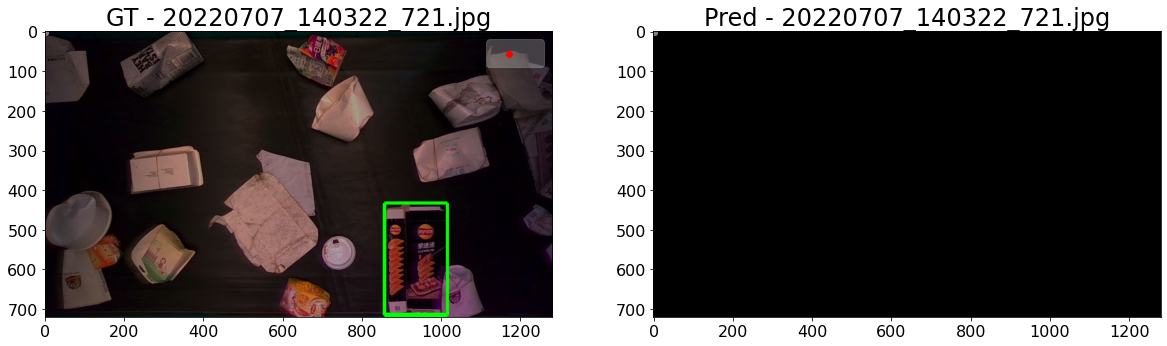

In [7]:
for iou,antPath,imgPath,linei,linej in sorted(obj.overlapL):
    print( iou, "\n", linei, linej[:-1])
    vis.show(imgPath, antPath, classList=[""])